# EV DoS Attack — Comprehensive Feature Analysis
**Scenario**: `Toy_DoS` (3×3 grid, 2 EVs, 1 CS, 1 RSU, 300s)  
**Goal**: Analyze every feature in the CSV data, with focus on energy/power and EV–CS communication.  
**Key question**: How does a DoS attack impact charging, energy, and network metrics?

In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

# Load all 4 CSV files
ev0 = pd.read_csv('results/Toy_Synchronized_ev0.csv')
ev1 = pd.read_csv('results/Toy_Synchronized_ev1.csv')
cs0 = pd.read_csv('results/Toy_Synchronized_cs0.csv')
rsu0 = pd.read_csv('results/Toy_Synchronized_rsu0.csv')

# Constants from omnetpp.ini
CS_X, CS_Y = 200.0, 200.0
RSU_X, RSU_Y = 200.0, 300.0
CHARGE_RANGE = 300.0   # m
BATTERY_CAP = 200.0    # Wh
SOC_THRESHOLD = 0.20   # 20%
CS_BATTERY_CAP = 50000 # Wh
ATTACK_START = 15.0    # s
ATTACK_END = 75.0      # s (15 + 60)

# Precompute distance to CS for both EVs
ev0['dist_to_cs'] = np.sqrt((ev0.pos_x - CS_X)**2 + (ev0.pos_y - CS_Y)**2)
ev1['dist_to_cs'] = np.sqrt((ev1.pos_x - CS_X)**2 + (ev1.pos_y - CS_Y)**2)

print(f'ev0 (attacker): {len(ev0)} rows, t=[{ev0.timestamp.min():.1f}, {ev0.timestamp.max():.1f}]s')
print(f'ev1 (normal):   {len(ev1)} rows, t=[{ev1.timestamp.min():.1f}, {ev1.timestamp.max():.1f}]s')
print(f'cs0:            {len(cs0)} rows, t=[{cs0.timestamp.min():.1f}, {cs0.timestamp.max():.1f}]s')
print(f'rsu0:           {len(rsu0)} rows, t=[{rsu0.timestamp.min():.1f}, {rsu0.timestamp.max():.1f}]s')

ev0 (attacker): 28379 rows, t=[6.4, 299.3]s
ev1 (normal):   739 rows, t=[10.8, 211.3]s
cs0:            28578 rows, t=[1.0, 300.0]s
rsu0:           805 rows, t=[6.4, 299.3]s


---
## 1. Dataset Overview
Summary statistics for every feature, broken down by node.

In [439]:
# Per-node summary
for name, df in [('ev0 (attacker)', ev0), ('ev1 (normal)', ev1), ('cs0', cs0), ('rsu0', rsu0)]:
    print(f'\n{"="*60}')
    print(f'  {name}  ({len(df)} rows)')
    print(f'{"="*60}')
    print(f'  Event types:  {df.event_type.value_counts().to_dict()}')
    print(f'  Comm types:   {df.communication_type.value_counts().to_dict()}')
    numeric_cols = ['packet_size','inter_arrival_time','battery_level',
                    'energy_consumption','speed','tx_duration_est','soc']
    for c in numeric_cols:
        if c in df.columns:
            print(f'  {c:25s}: min={df[c].min():.4f}  max={df[c].max():.4f}  mean={df[c].mean():.4f}')


  ev0 (attacker)  (28379 rows)
  Event types:  {'SENT': 27921, 'RECEIVED': 345, 'CHARGING': 102, 'WAITING': 9, 'CHARGE_START': 1, 'CHARGE_END': 1}
  Comm types:   {'EV2CS': 27451, 'BSM': 795, 'CS2EV': 114, 'ChargeReq': 18, 'ChargeDone': 1}
  packet_size              : min=0.0000  max=1500.0000  mean=847.0027
  inter_arrival_time       : min=0.0000  max=26.5791  mean=0.0216
  battery_level            : min=0.0000  max=200.0000  mean=114.1977
  energy_consumption       : min=0.0000  max=244.9381  mean=48.0591
  speed                    : min=0.0000  max=15.5047  mean=12.6312
  tx_duration_est          : min=0.0000  max=0.0020  mean=0.0011
  soc                      : min=0.0000  max=1.0000  mean=0.5710

  ev1 (normal)  (739 rows)
  Event types:  {'SENT': 337, 'RECEIVED': 308, 'CHARGING': 91, 'WAITING': 1, 'CHARGE_START': 1, 'CHARGE_END': 1}
  Comm types:   {'BSM': 633, 'CS2EV': 103, 'ChargeReq': 2, 'ChargeDone': 1}
  packet_size              : min=0.0000  max=400.0000  mean=261.4790
  i

---
## 2. Event Type and Communication Type Breakdown
Compare the volume and mix of events between attacker and normal EV.

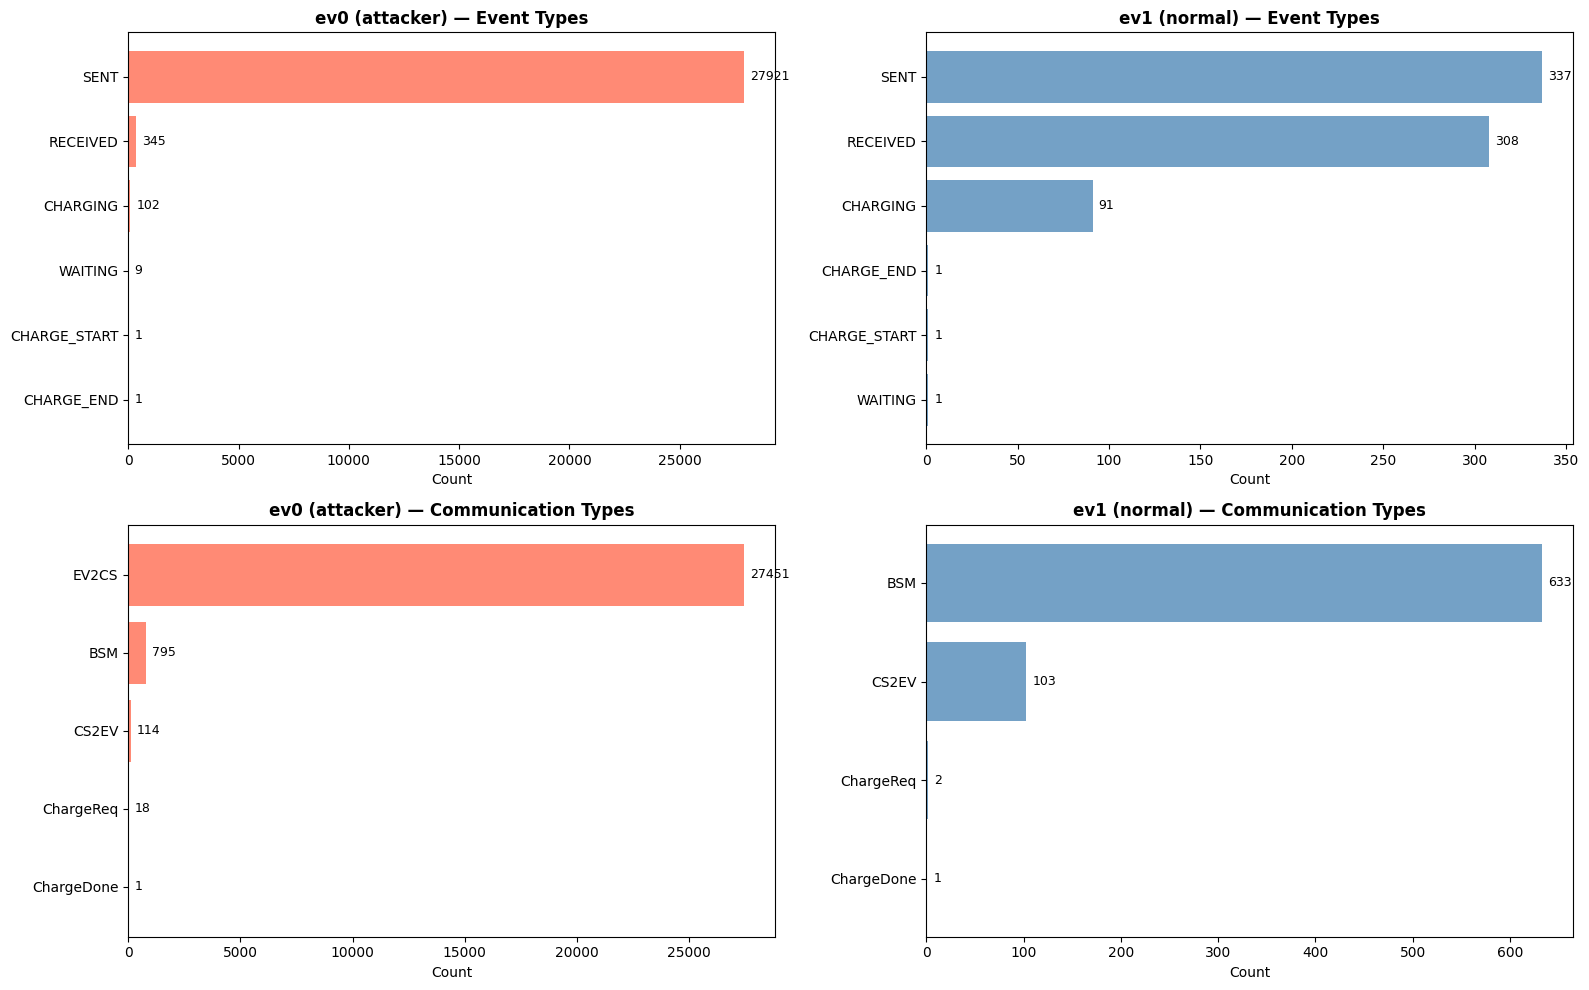


Key difference: ev0 sends ~6x more packets than ev1 due to DoS flood.


In [440]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Row 1: Event types
for ax, name, df, color in [(axes[0,0], 'ev0 (attacker)', ev0, 'tomato'),
                             (axes[0,1], 'ev1 (normal)', ev1, 'steelblue')]:
    counts = df['event_type'].value_counts().sort_values()
    bars = ax.barh(counts.index, counts.values, color=color, alpha=0.75)
    for b, v in zip(bars, counts.values):
        ax.text(v + counts.max()*0.01, b.get_y()+b.get_height()/2, str(v), va='center', fontsize=9)
    ax.set_title(f'{name} \u2014 Event Types', fontweight='bold')
    ax.set_xlabel('Count')

# Row 2: Communication types
for ax, name, df, color in [(axes[1,0], 'ev0 (attacker)', ev0, 'tomato'),
                             (axes[1,1], 'ev1 (normal)', ev1, 'steelblue')]:
    counts = df['communication_type'].value_counts().sort_values()
    bars = ax.barh(counts.index, counts.values, color=color, alpha=0.75)
    for b, v in zip(bars, counts.values):
        ax.text(v + counts.max()*0.01, b.get_y()+b.get_height()/2, str(v), va='center', fontsize=9)
    ax.set_title(f'{name} \u2014 Communication Types', fontweight='bold')
    ax.set_xlabel('Count')

plt.tight_layout()
plt.savefig('results/fig01_event_comm_types.png', dpi=150, bbox_inches='tight')
plt.show()
print('\nKey difference: ev0 sends ~6x more packets than ev1 due to DoS flood.')

---
## 3. Packet Rate Over Time (DoS Traffic Pattern)
Visualizes how the attacker floods the network during the attack window.

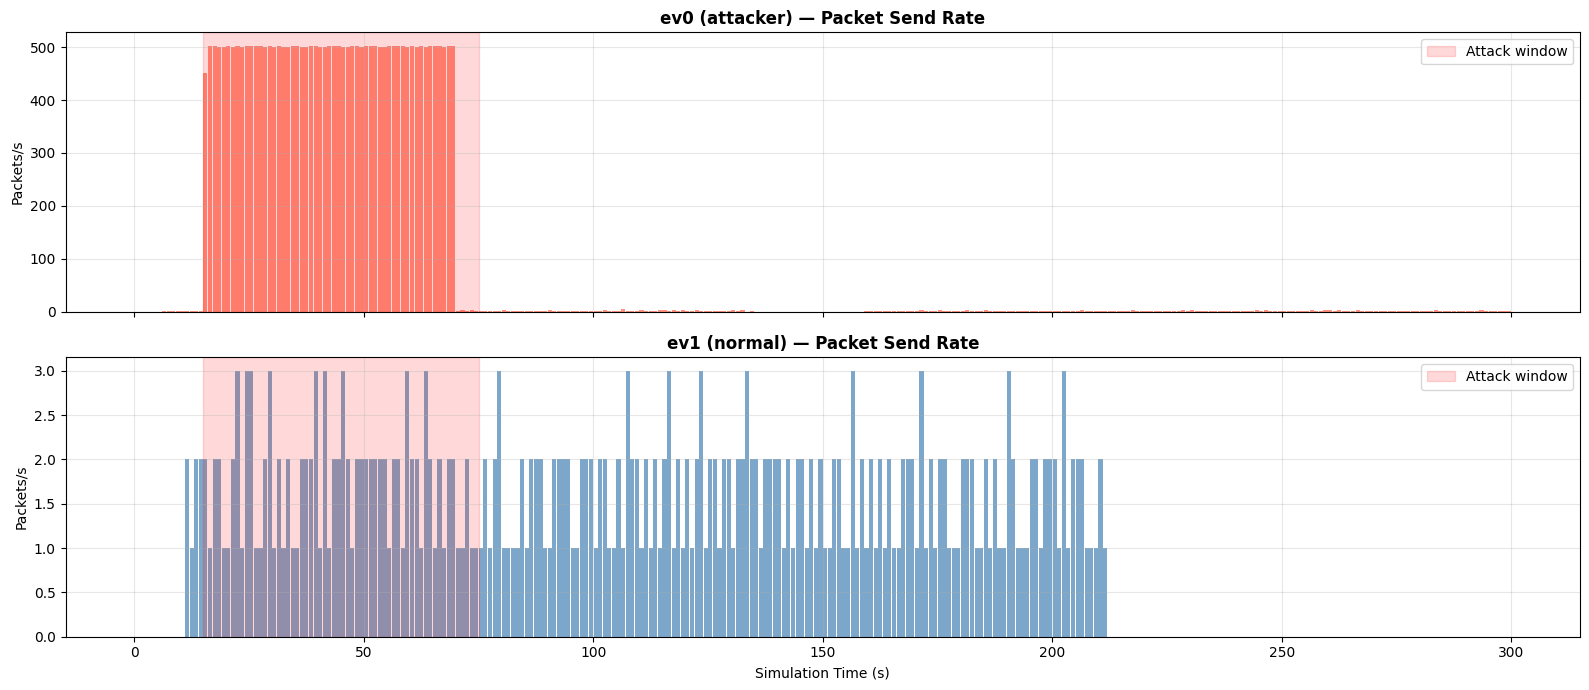

ev0 peak rate: 503 pkts/s (during DoS flood)
ev0 normal rate: ~2 pkts/s (outside attack)
ev1 peak rate: 3 pkts/s (always normal BSM)


In [441]:
# Count packets per 1-second bin for each EV
def packet_rate(df, bin_size=1.0):
    sent = df[df.event_type == 'SENT']
    bins = np.arange(0, df.timestamp.max() + bin_size, bin_size)
    counts, edges = np.histogram(sent.timestamp, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    return centers, counts

fig, axes = plt.subplots(2, 1, figsize=(16, 7), sharex=True)

t0, r0 = packet_rate(ev0)
t1, r1 = packet_rate(ev1)

axes[0].bar(t0, r0, width=0.9, color='tomato', alpha=0.7)
axes[0].axvspan(ATTACK_START, ATTACK_END, alpha=0.15, color='red', label='Attack window')
axes[0].set_ylabel('Packets/s')
axes[0].set_title('ev0 (attacker) \u2014 Packet Send Rate', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(t1, r1, width=0.9, color='steelblue', alpha=0.7)
axes[1].axvspan(ATTACK_START, ATTACK_END, alpha=0.15, color='red', label='Attack window')
axes[1].set_ylabel('Packets/s')
axes[1].set_xlabel('Simulation Time (s)')
axes[1].set_title('ev1 (normal) \u2014 Packet Send Rate', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/fig02_packet_rate.png', dpi=150, bbox_inches='tight')
plt.show()

# Print peak rates
print(f'ev0 peak rate: {r0.max()} pkts/s (during DoS flood)')
print(f'ev0 normal rate: ~{np.median(r0[r0 > 0]):.0f} pkts/s (outside attack)')
print(f'ev1 peak rate: {r1.max()} pkts/s (always normal BSM)')

---
## 4. Packet Size Distribution
Compare the packet size profiles of attacker vs normal EV.

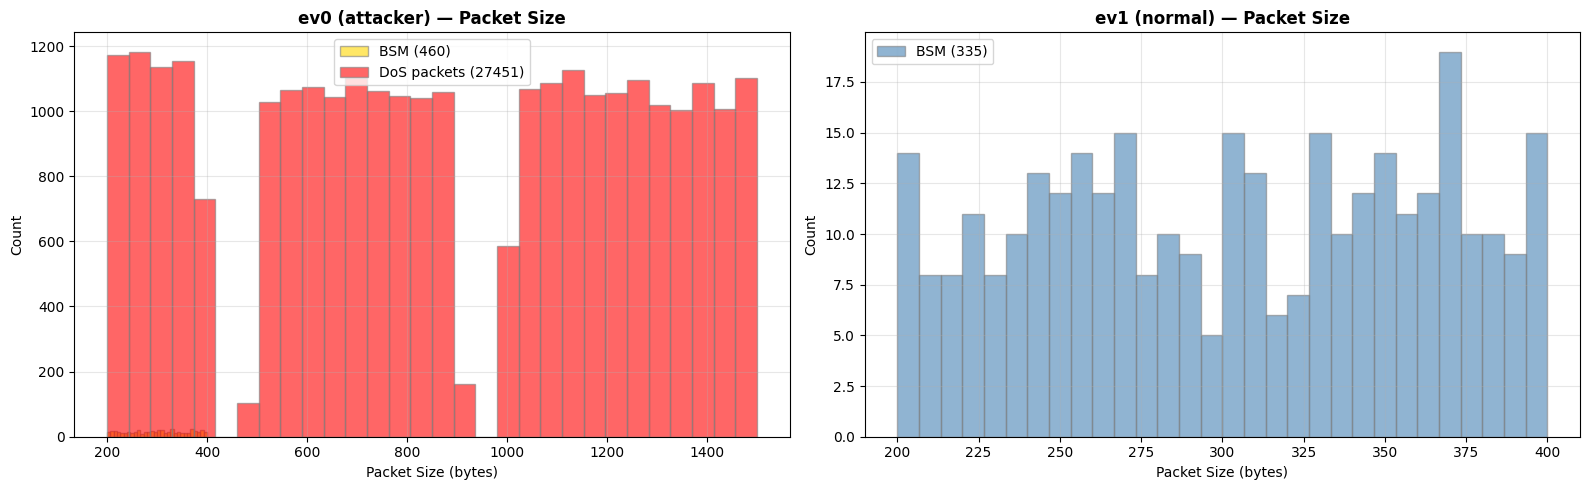

DoS packet size: 867 bytes (configured: 1024B)
Normal BSM size: 302 bytes (random 200-400B)


In [442]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ev0: separate attack packets from normal BSMs
ev0_attack = ev0[(ev0.timestamp >= ATTACK_START) & (ev0.timestamp <= ATTACK_END) &
                 (ev0.communication_type == 'EV2CS') & (ev0.event_type == 'SENT')]
ev0_bsm = ev0[(ev0.communication_type == 'BSM') & (ev0.event_type == 'SENT')]

axes[0].hist(ev0_bsm.packet_size, bins=30, alpha=0.6, color='gold', label=f'BSM ({len(ev0_bsm)})', edgecolor='gray')
axes[0].hist(ev0_attack.packet_size, bins=30, alpha=0.6, color='red', label=f'DoS packets ({len(ev0_attack)})', edgecolor='gray')
axes[0].set_title('ev0 (attacker) \u2014 Packet Size', fontweight='bold')
axes[0].set_xlabel('Packet Size (bytes)')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

ev1_bsm = ev1[(ev1.communication_type == 'BSM') & (ev1.event_type == 'SENT')]
axes[1].hist(ev1_bsm.packet_size, bins=30, alpha=0.6, color='steelblue', label=f'BSM ({len(ev1_bsm)})', edgecolor='gray')
axes[1].set_title('ev1 (normal) \u2014 Packet Size', fontweight='bold')
axes[1].set_xlabel('Packet Size (bytes)')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/fig03_packet_size.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'DoS packet size: {ev0_attack.packet_size.mean():.0f} bytes (configured: 1024B)')
print(f'Normal BSM size: {ev0_bsm.packet_size.mean():.0f} bytes (random 200-400B)')

---
## 5. Inter-Arrival Time (IAT)
During a DoS attack, IAT drops dramatically. This is the key detection feature.

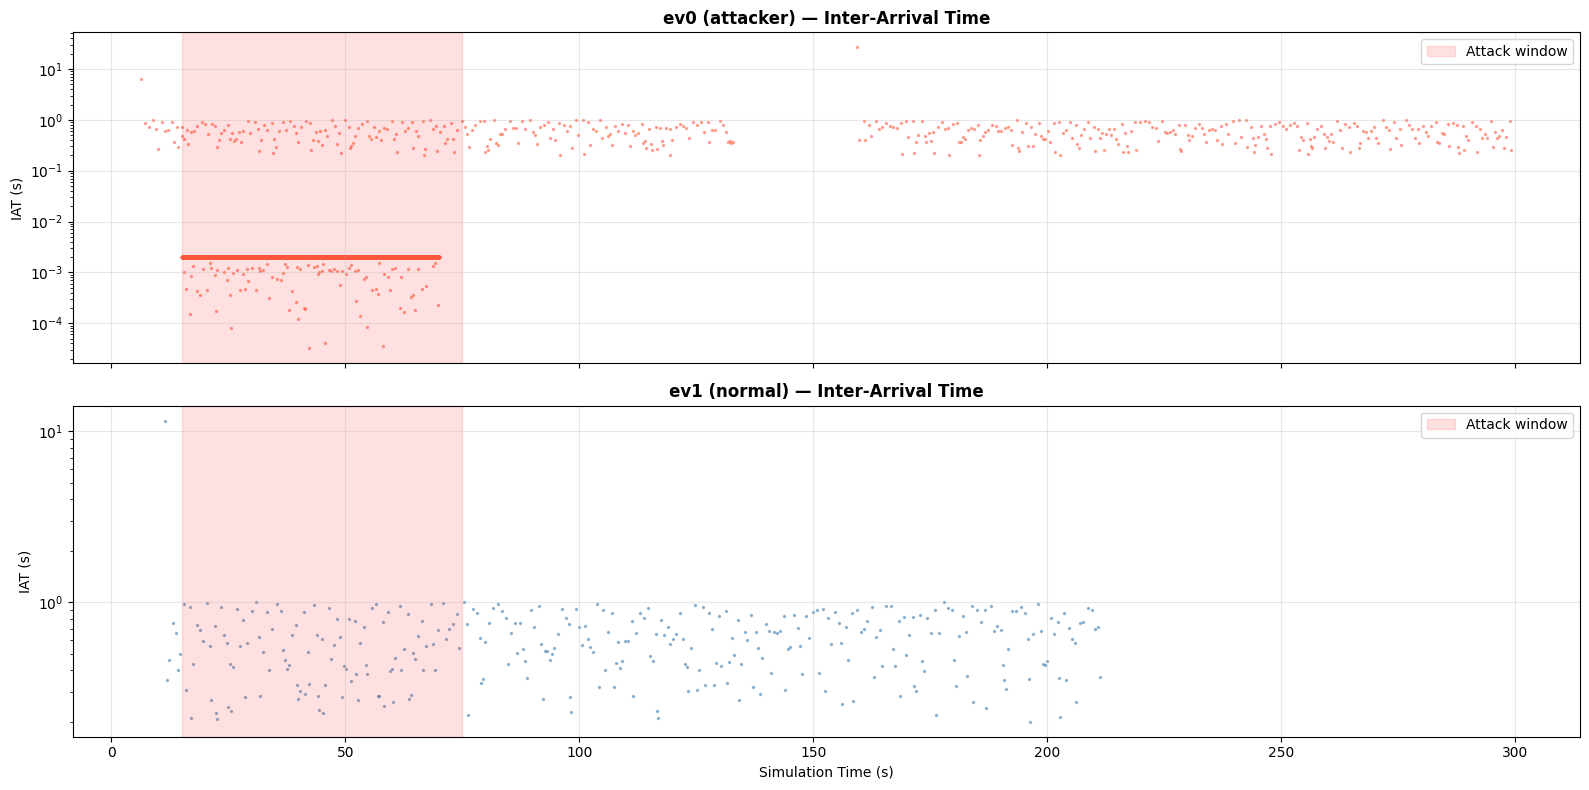

ev0 IAT during attack:  mean=0.0042s
ev0 IAT outside attack: mean=0.6505s
ev1 IAT (always normal): mean=0.6271s

Ratio: normal IAT is ~155x larger than attack IAT


In [443]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# ev0 IAT over time
ev0_sent = ev0[ev0.event_type == 'SENT']
axes[0].scatter(ev0_sent.timestamp, ev0_sent.inter_arrival_time, s=2, alpha=0.5, c='tomato')
axes[0].axvspan(ATTACK_START, ATTACK_END, alpha=0.12, color='red', label='Attack window')
axes[0].set_ylabel('IAT (s)')
axes[0].set_title('ev0 (attacker) \u2014 Inter-Arrival Time', fontweight='bold')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ev1 IAT over time
ev1_sent = ev1[ev1.event_type == 'SENT']
axes[1].scatter(ev1_sent.timestamp, ev1_sent.inter_arrival_time, s=2, alpha=0.5, c='steelblue')
axes[1].axvspan(ATTACK_START, ATTACK_END, alpha=0.12, color='red', label='Attack window')
axes[1].set_ylabel('IAT (s)')
axes[1].set_xlabel('Simulation Time (s)')
axes[1].set_title('ev1 (normal) \u2014 Inter-Arrival Time', fontweight='bold')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/fig04_iat.png', dpi=150, bbox_inches='tight')
plt.show()

# Stats
ev0_during = ev0_sent[(ev0_sent.timestamp >= ATTACK_START) & (ev0_sent.timestamp <= ATTACK_END)]
ev0_outside = ev0_sent[(ev0_sent.timestamp < ATTACK_START) | (ev0_sent.timestamp > ATTACK_END)]
print(f'ev0 IAT during attack:  mean={ev0_during.inter_arrival_time.mean():.4f}s')
print(f'ev0 IAT outside attack: mean={ev0_outside.inter_arrival_time.mean():.4f}s')
print(f'ev1 IAT (always normal): mean={ev1_sent.inter_arrival_time.mean():.4f}s')
print(f'\nRatio: normal IAT is ~{ev0_outside.inter_arrival_time.mean()/ev0_during.inter_arrival_time.mean():.0f}x larger than attack IAT')

---
## 9. Distance to CS and Charging Trigger
Shows when each EV enters the 300m charging range with low SoC.

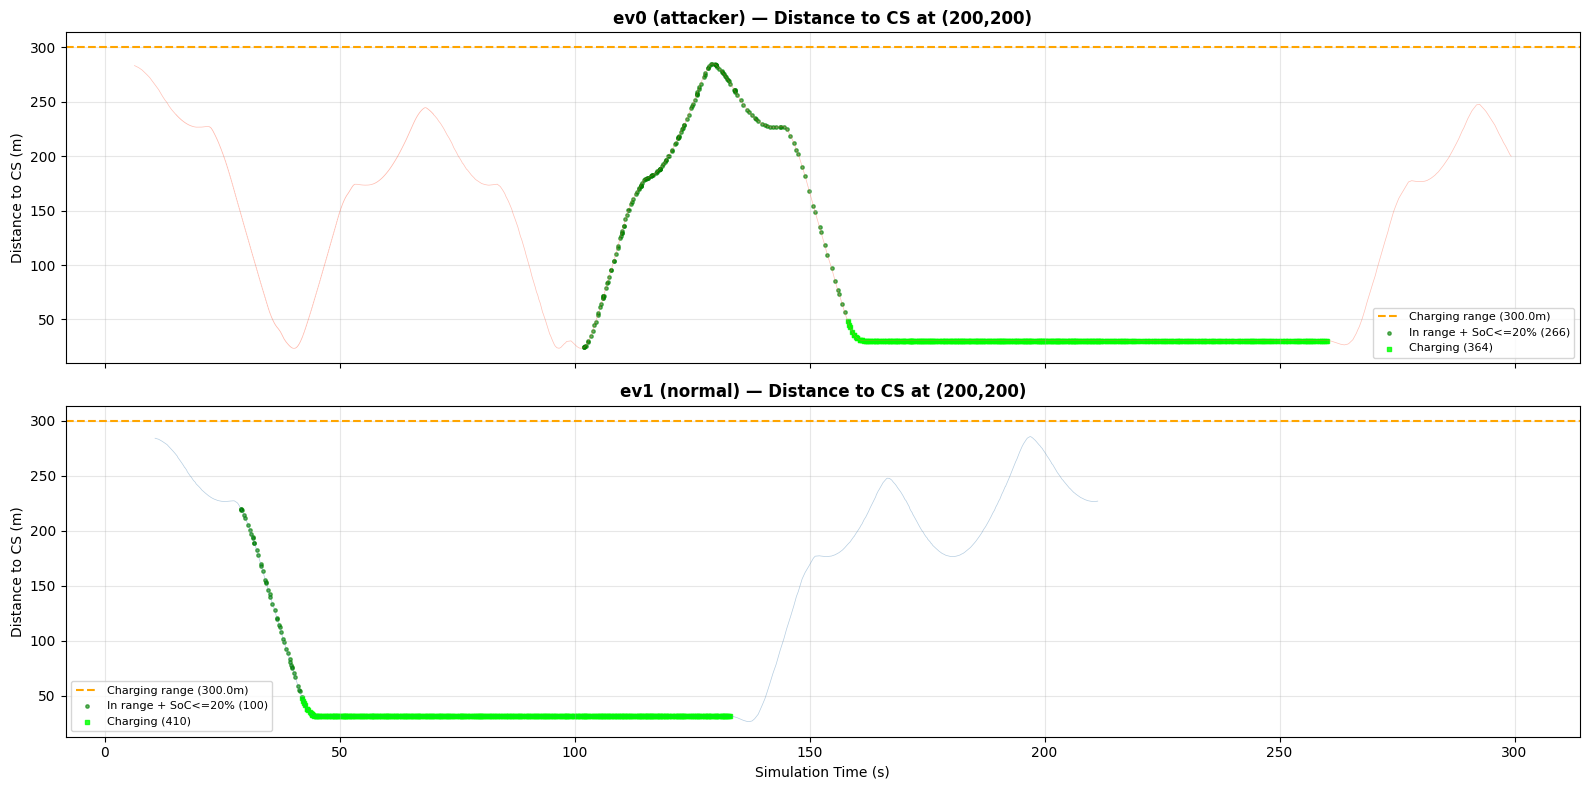

In [444]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

for ax, name, df, color in [(axes[0], 'ev0 (attacker)', ev0, 'tomato'),
                             (axes[1], 'ev1 (normal)', ev1, 'steelblue')]:
    ax.plot(df.timestamp, df.dist_to_cs, color=color, alpha=0.4, linewidth=0.5)
    ax.axhline(y=CHARGE_RANGE, color='orange', ls='--', lw=1.5, label=f'Charging range ({CHARGE_RANGE}m)')

    # In range with low SoC
    low_in = df[(df.soc <= SOC_THRESHOLD) & (df.dist_to_cs < CHARGE_RANGE)]
    if len(low_in) > 0:
        ax.scatter(low_in.timestamp, low_in.dist_to_cs, c='green', s=6, alpha=0.6,
                   label=f'In range + SoC<=20% ({len(low_in)})')

    # Charging
    c = df[df.is_charging == 1]
    if len(c) > 0:
        ax.scatter(c.timestamp, c.dist_to_cs, c='lime', s=8, marker='s', alpha=0.8,
                   label=f'Charging ({len(c)})')

    ax.set_ylabel('Distance to CS (m)')
    ax.set_title(f'{name} \u2014 Distance to CS at (200,200)', fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

axes[1].set_xlabel('Simulation Time (s)')
plt.tight_layout()
plt.savefig('results/fig08_distance_cs.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 15. TX Duration Estimate
Compare transmission duration distribution between attacker and normal traffic.

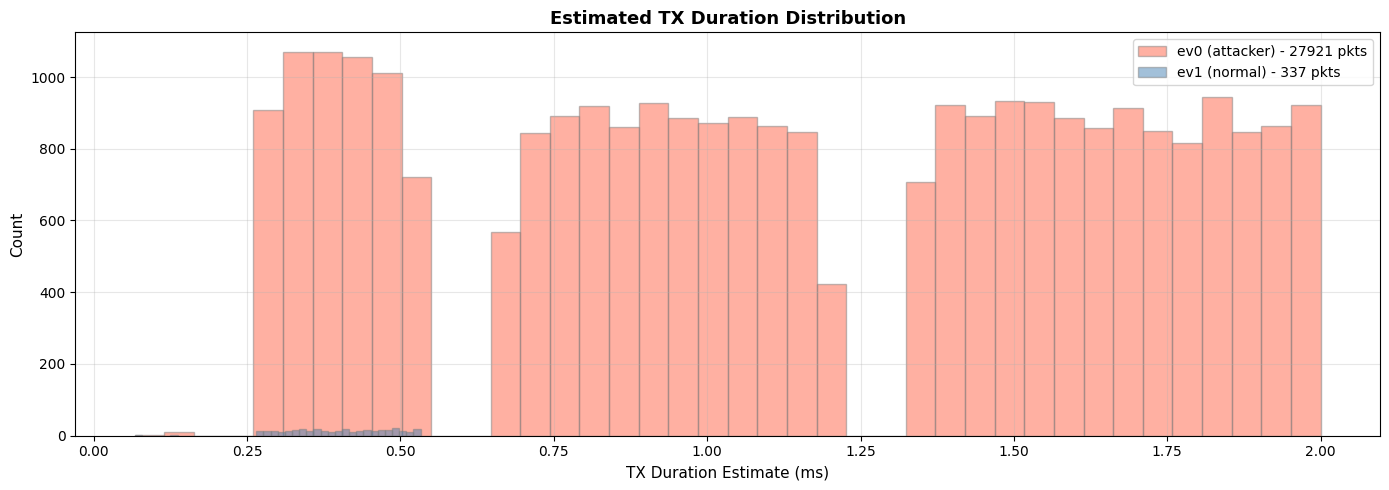

ev0 mean TX duration: 1.143 ms
ev1 mean TX duration: 0.402 ms


In [445]:
fig, ax = plt.subplots(figsize=(14, 5))

ev0_sent = ev0[ev0.event_type == 'SENT']
ev1_sent = ev1[ev1.event_type == 'SENT']

ax.hist(ev0_sent.tx_duration_est * 1000, bins=40, alpha=0.5, color='tomato',
        label=f'ev0 (attacker) - {len(ev0_sent)} pkts', edgecolor='gray')
ax.hist(ev1_sent.tx_duration_est * 1000, bins=40, alpha=0.5, color='steelblue',
        label=f'ev1 (normal) - {len(ev1_sent)} pkts', edgecolor='gray')
ax.set_xlabel('TX Duration Estimate (ms)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Estimated TX Duration Distribution', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/fig13_tx_duration.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'ev0 mean TX duration: {ev0_sent.tx_duration_est.mean()*1000:.3f} ms')
print(f'ev1 mean TX duration: {ev1_sent.tx_duration_est.mean()*1000:.3f} ms')

---
## 16. Cumulative Packets Sent/Received
Shows how the attacker generates a massive number of packets compared to the normal EV.

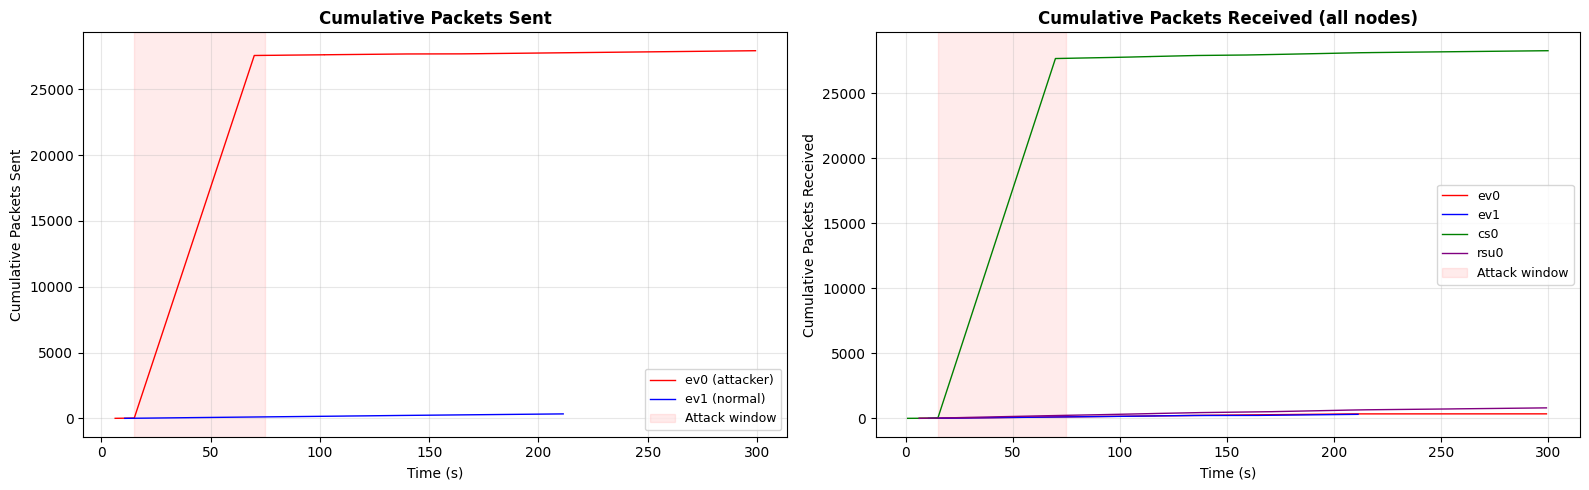

ev0 total sent: 27921
ev1 total sent: 337
cs0 total received: 28268
rsu0 total received: 805


In [446]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative sent
ax1 = axes[0]
ax1.plot(ev0.timestamp, ev0.cumulative_packets_sent, 'r-', linewidth=1, label='ev0 (attacker)')
ax1.plot(ev1.timestamp, ev1.cumulative_packets_sent, 'b-', linewidth=1, label='ev1 (normal)')
ax1.axvspan(ATTACK_START, ATTACK_END, alpha=0.08, color='red', label='Attack window')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cumulative Packets Sent')
ax1.set_title('Cumulative Packets Sent', fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Cumulative received
ax2 = axes[1]
ax2.plot(ev0.timestamp, ev0.cumulative_packets_received, 'r-', linewidth=1, label='ev0')
ax2.plot(ev1.timestamp, ev1.cumulative_packets_received, 'b-', linewidth=1, label='ev1')
ax2.plot(cs0.timestamp, cs0.cumulative_packets_received, 'g-', linewidth=1, label='cs0')
ax2.plot(rsu0.timestamp, rsu0.cumulative_packets_received, 'purple', linewidth=1, label='rsu0')
ax2.axvspan(ATTACK_START, ATTACK_END, alpha=0.08, color='red', label='Attack window')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cumulative Packets Received')
ax2.set_title('Cumulative Packets Received (all nodes)', fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/fig14_cumulative_packets.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'ev0 total sent: {ev0.cumulative_packets_sent.max()}')
print(f'ev1 total sent: {ev1.cumulative_packets_sent.max()}')
print(f'cs0 total received: {cs0.cumulative_packets_received.max()}')
print(f'rsu0 total received: {rsu0.cumulative_packets_received.max()}')

---
## 17. RSU Traffic Analysis
What the RSU sees: all BSMs from both EVs, including DoS flood.

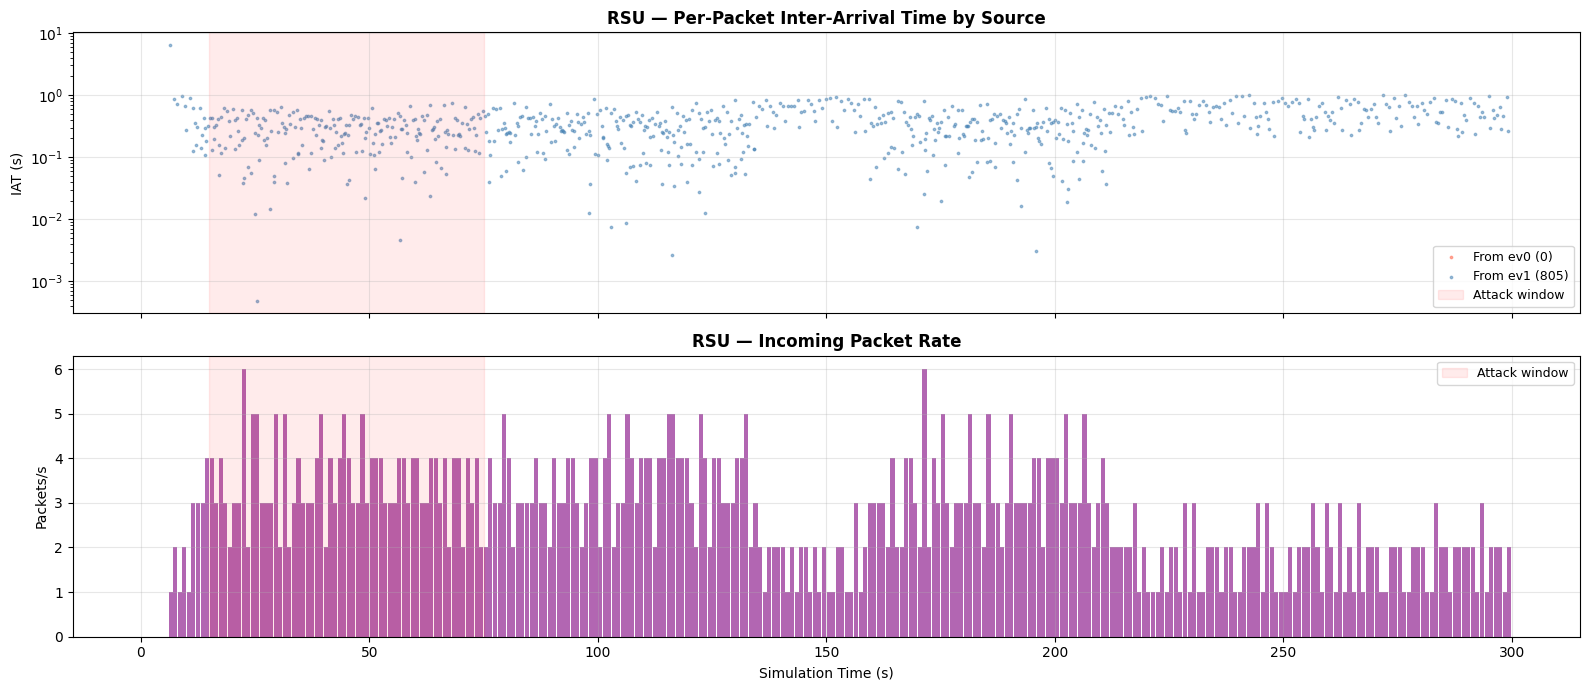

In [447]:
fig, axes = plt.subplots(2, 1, figsize=(16, 7), sharex=True)

# RSU: IAT over time
ax1 = axes[0]
rsu0_ev0 = rsu0[rsu0.source_address == '10.0.0.157']  # ev0=attacker
rsu0_ev1 = rsu0[rsu0.source_address != '10.0.0.157']  # ev1=normal

# Get actual source addresses if different
ev0_addr = ev0[ev0.event_type == 'SENT'].source_address.iloc[0] if len(ev0[ev0.event_type == 'SENT']) > 0 else '10.0.0.157'
rsu0_from_ev0 = rsu0[rsu0.source_address == ev0_addr]
rsu0_from_ev1 = rsu0[rsu0.source_address != ev0_addr]

ax1.scatter(rsu0_from_ev0.timestamp, rsu0_from_ev0.inter_arrival_time, c='tomato', s=3, alpha=0.5, label=f'From ev0 ({len(rsu0_from_ev0)})')
ax1.scatter(rsu0_from_ev1.timestamp, rsu0_from_ev1.inter_arrival_time, c='steelblue', s=3, alpha=0.5, label=f'From ev1 ({len(rsu0_from_ev1)})')
ax1.axvspan(ATTACK_START, ATTACK_END, alpha=0.08, color='red', label='Attack window')
ax1.set_ylabel('IAT (s)')
ax1.set_title('RSU \u2014 Per-Packet Inter-Arrival Time by Source', fontweight='bold')
ax1.set_yscale('log')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# RSU: packet rate
ax2 = axes[1]
bins = np.arange(0, rsu0.timestamp.max() + 1, 1)
counts_all, _ = np.histogram(rsu0.timestamp, bins=bins)
centers = (bins[:-1] + bins[1:]) / 2
ax2.bar(centers, counts_all, width=0.9, color='purple', alpha=0.6)
ax2.axvspan(ATTACK_START, ATTACK_END, alpha=0.08, color='red', label='Attack window')
ax2.set_ylabel('Packets/s')
ax2.set_xlabel('Simulation Time (s)')
ax2.set_title('RSU \u2014 Incoming Packet Rate', fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/fig15_rsu_traffic.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 22. Combined Attack Impact Dashboard
A single figure summarizing the key DoS impact metrics.

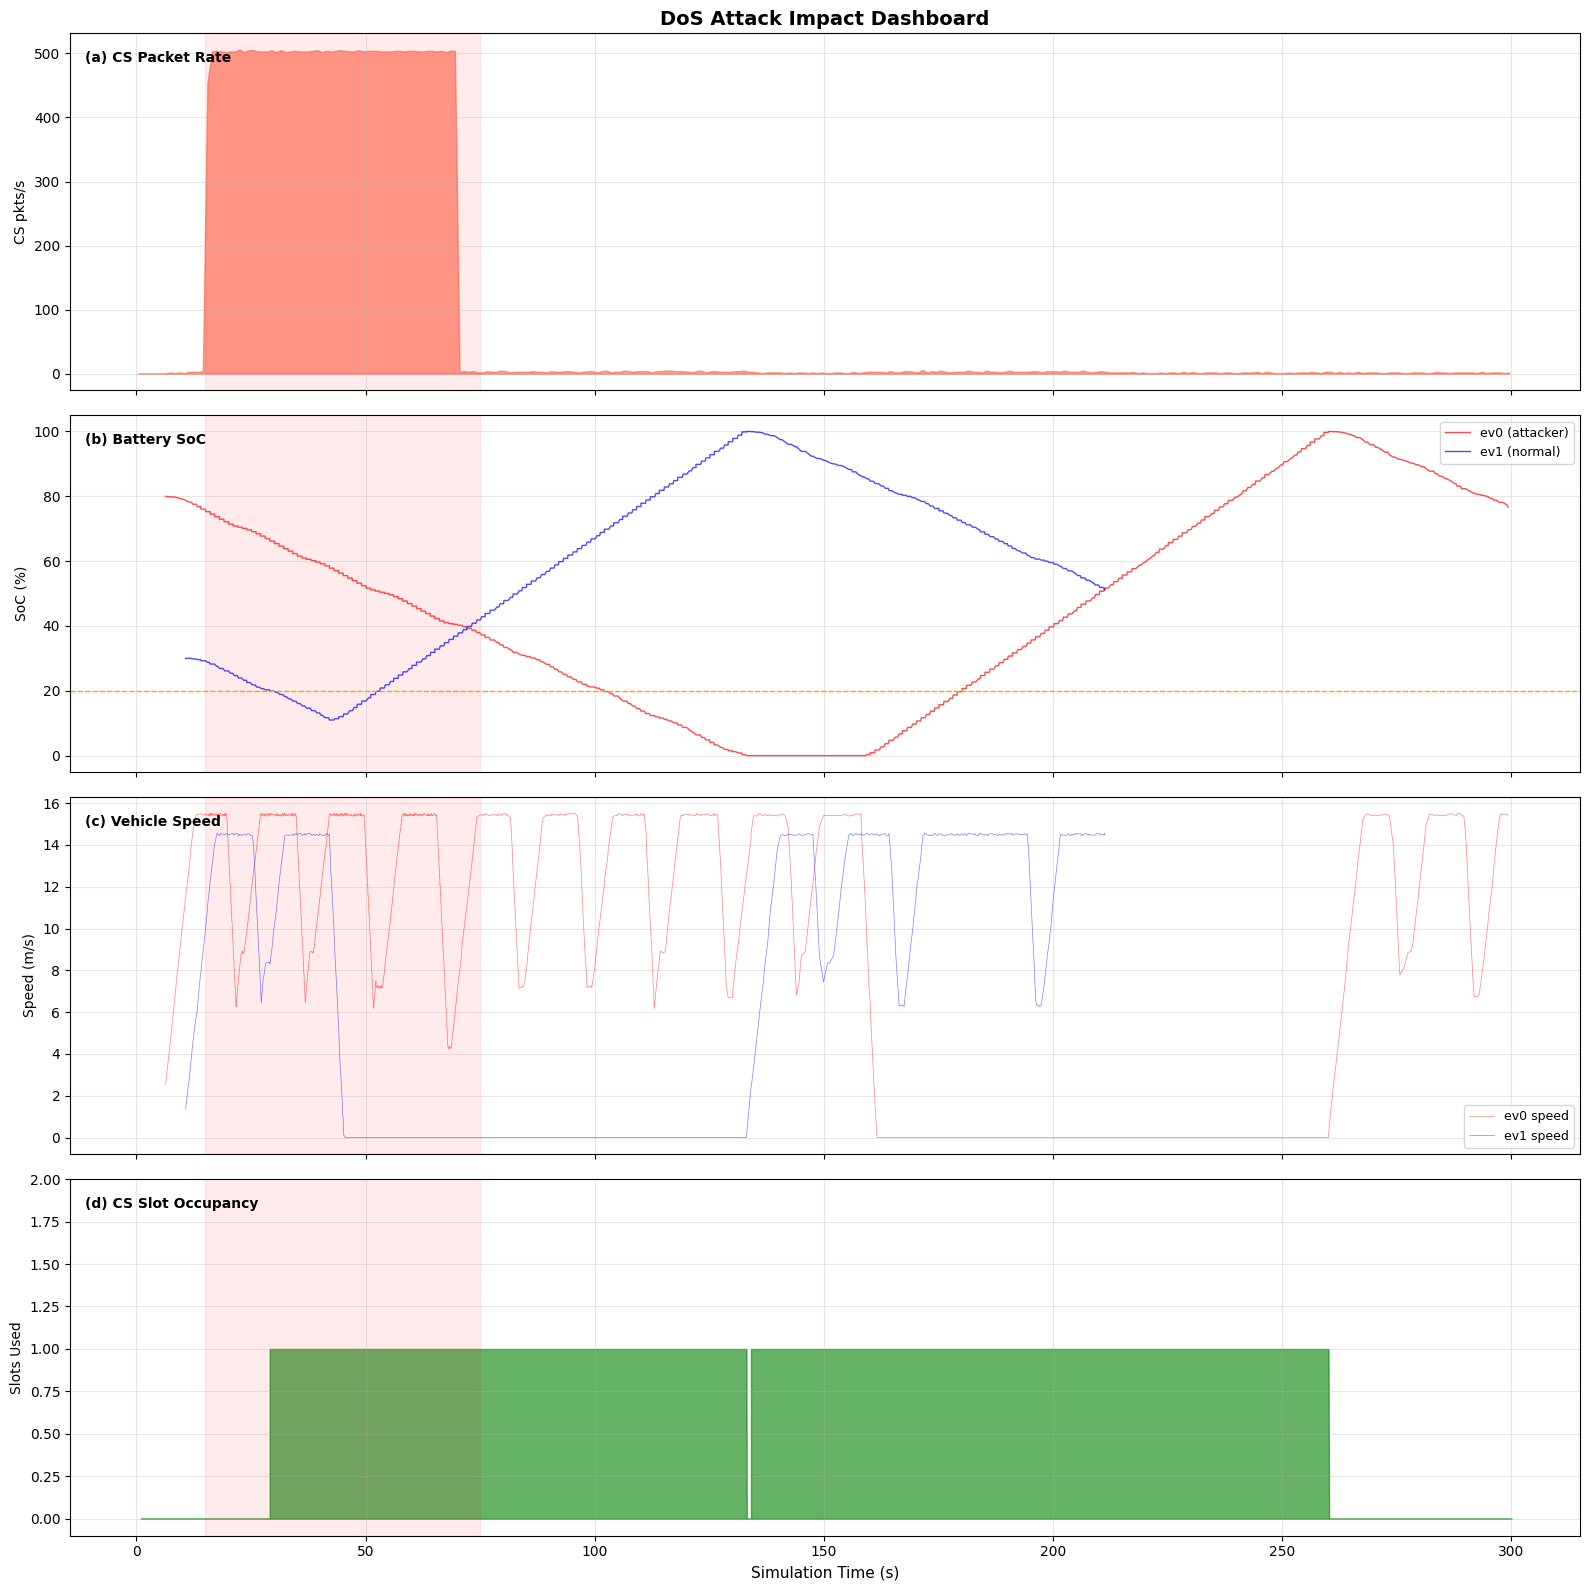

In [448]:
fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

# (a) Packet rate at CS
ax = axes[0]
cs_recv = cs0[cs0.event_type == 'RECEIVED']
bins = np.arange(0, 301, 1)
counts_cs, _ = np.histogram(cs_recv.timestamp, bins=bins)
centers_cs = (bins[:-1] + bins[1:]) / 2
ax.fill_between(centers_cs, counts_cs, alpha=0.6, color='tomato')
ax.axvspan(ATTACK_START, ATTACK_END, alpha=0.08, color='red')
ax.set_ylabel('CS pkts/s', fontsize=10)
ax.set_title('DoS Attack Impact Dashboard', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.text(0.01, 0.95, '(a) CS Packet Rate', transform=ax.transAxes, fontweight='bold', fontsize=10, va='top')

# (b) EV SoC
ax = axes[1]
ax.plot(ev0.timestamp, ev0.soc*100, 'r-', lw=1, alpha=0.7, label='ev0 (attacker)')
ax.plot(ev1.timestamp, ev1.soc*100, 'b-', lw=1, alpha=0.7, label='ev1 (normal)')
ax.axhline(y=20, color='orange', ls='--', lw=1)
ax.axvspan(ATTACK_START, ATTACK_END, alpha=0.08, color='red')
ax.set_ylabel('SoC (%)', fontsize=10)
ax.set_ylim(-5, 105)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.text(0.01, 0.95, '(b) Battery SoC', transform=ax.transAxes, fontweight='bold', fontsize=10, va='top')

# (c) Vehicle speed
ax = axes[2]
ax.plot(ev0.timestamp, ev0.speed, 'r-', lw=0.5, alpha=0.5, label='ev0 speed')
ax.plot(ev1.timestamp, ev1.speed, 'b-', lw=0.5, alpha=0.5, label='ev1 speed')
ax.axvspan(ATTACK_START, ATTACK_END, alpha=0.08, color='red')
ax.set_ylabel('Speed (m/s)', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.text(0.01, 0.95, '(c) Vehicle Speed', transform=ax.transAxes, fontweight='bold', fontsize=10, va='top')

# (d) CS slot usage
ax = axes[3]
ax.fill_between(cs0.timestamp, cs0.is_charging, alpha=0.6, color='green')
ax.axvspan(ATTACK_START, ATTACK_END, alpha=0.08, color='red')
ax.set_ylabel('Slots Used', fontsize=10)
ax.set_xlabel('Simulation Time (s)', fontsize=11)
ax.set_ylim(-0.1, 2)
ax.grid(True, alpha=0.3)
ax.text(0.01, 0.95, '(d) CS Slot Occupancy', transform=ax.transAxes, fontweight='bold', fontsize=10, va='top')

# Attack window annotation
for a in axes:
    a.annotate('', xy=(ATTACK_START, 0), xytext=(ATTACK_END, 0))

plt.tight_layout()
plt.savefig('results/fig18_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 23. Summary Statistics Table
Final quantitative comparison of all key metrics.

In [449]:
# Build summary table
summary = pd.DataFrame({
    'Metric': [
        'Total rows',
        'Total packets sent',
        'Total packets received',
        'SoC min (%)',
        'SoC max (%)',
        'Battery min (Wh)',
        'Battery max (Wh)',
        'Energy consumed (Wh)',
        'is_charging=1 rows',
        'Charge duration (s)',
        'Mean speed (m/s)',
        'Mean packet size (B)',
        'Mean IAT (s)',
        'Min IAT (s)',
        'ChargeReq count',
        'BUSY responses',
        'AVAILABLE responses',
    ]
})

def get_metrics(df, name):
    sent = df[df.event_type == 'SENT']
    c = df[df.is_charging == 1]
    charge_dur = c.timestamp.max() - c.timestamp.min() if len(c) > 0 else 0
    busy = df[df.packet_name.str.contains('BUSY', na=False)]
    avail = df[df.packet_name.str.contains('AVAILABLE', na=False)]
    req = df[df.communication_type == 'ChargeReq']
    soc_col = df.soc if 'soc' in df.columns else pd.Series([0])
    return [
        len(df),
        int(df.cumulative_packets_sent.max()) if 'cumulative_packets_sent' in df.columns else 0,
        int(df.cumulative_packets_received.max()),
        f'{soc_col.min()*100:.1f}',
        f'{soc_col.max()*100:.1f}',
        f'{df.battery_level.min():.1f}',
        f'{df.battery_level.max():.1f}',
        f'{df.energy_consumption.max():.2f}',
        len(c),
        f'{charge_dur:.0f}',
        f'{df.speed.mean():.2f}',
        f'{sent.packet_size.mean():.0f}' if len(sent) > 0 else 'N/A',
        f'{sent.inter_arrival_time.mean():.4f}' if len(sent) > 0 else 'N/A',
        f'{sent.inter_arrival_time.min():.4f}' if len(sent) > 0 else 'N/A',
        len(req),
        len(busy),
        len(avail),
    ]

summary['ev0 (attacker)'] = get_metrics(ev0, 'ev0')
summary['ev1 (normal)'] = get_metrics(ev1, 'ev1')

print(summary.to_string(index=False))

                Metric ev0 (attacker) ev1 (normal)
            Total rows          28379          739
    Total packets sent          27921          337
Total packets received            345          308
           SoC min (%)            0.0         11.0
           SoC max (%)          100.0        100.0
      Battery min (Wh)            0.0         22.0
      Battery max (Wh)          200.0        200.0
  Energy consumed (Wh)         244.94       137.90
    is_charging=1 rows            364          410
   Charge duration (s)            102           91
      Mean speed (m/s)          12.63         5.71
  Mean packet size (B)            857          302
          Mean IAT (s)         0.0127       0.6271
           Min IAT (s)         0.0000       0.0000
       ChargeReq count             18            2
        BUSY responses              8            8
   AVAILABLE responses              2            2
